In [1]:
import re
from functools import reduce
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dask import dataframe as ddf

# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def round_(data : float):
    return str(round(data, 4)*100) + '%'

In [3]:
%%time

maininfo = pd.read_csv('data/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
unitclassinfo = pd.read_csv('data/FUND_UnitClassInfo.csv', parse_dates=['ListingDate'])
allocation = pd.read_csv('data//Fund_Allocation.csv')

fees = ddf.read_csv('data/管理费率/*', dtype={'Symbol': 'object', 'ProportionOfFee': 'object'}, parse_dates=['DeclareDate']).compute()
fund_dividend = pd.read_csv('data/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
nav_month = pd.read_csv('data/Fund_NAV_Month.csv', parse_dates=['TradingDate'])
resolution = pd.read_csv('data/Fund_Resolution.csv', parse_dates=['DeclareDate'])
mkt_month = pd.read_csv('data/Fund_MKT_QuotationMonth.csv', parse_dates=['TradingDate'])


CPU times: total: 1.61 s
Wall time: 1.97 s


### #data-insight/EDA

 #**1. `Symbol`, `MasterFundCode`, `FundID`?**

`Symbol` is queryable in Win.d

`Symbol` translates as  `前端代码(Win.d)/基金代码(CSMAR)/前端代码(CSMAR)`

`Symbol == 11228` means `011228.OF`

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

`MasterFundCode` is the first `Symbol` in ***a collection of funds***

***a collection of funds, e.g.***

*西部利得量化成长A, 000006.OF, 2019-03-19*

*西部利得量化成长C, 011228.OF, 2021-01-13*

*or*

*中海可转债A, 000003.OF, 2013-03-20*

*中海可转债C, 000004.OF, 2013-03-20*

|            |                    | A      | C       |                          |
| ---------- | ------------------ | ------ | ------- | ------------------------ |
| 运作方式   | operation          | same   | same    |                          |
| 管理费     | management fee     | same   | same    |                          |
| 认购费     | purchase fee       | √     |         |                          |
| 销售服务费 | sales service fees |        | √      | charge from net value |
| 赎回费     | redemption fee    | bigger | smaller |                          |

*≈60%* `MasterFundCode` has multiple symbols

`MasterFundCode` can be inferred from `Symbol`

`FundID` is in bijection with `MasterFundCode`

`FundID` is not queryable in Win.d --> *`FundID` used by CSMAR only?*

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

**use `Symbol`**

 #**2. `InceptionDate`, `ListingDate`?**
 
`InceptionDate`: 成立日期

`ListingDate`: 上市日期

*<10%* `ListingDate` is available

*=100%* `InceptionDate` is available

*≈85%* collection of funds has the same `InceptionDate`

**use `InceptionDate`**

 #**3. `Equity`, `StockAmount`? `allocation` data quality**

`Equity` is ≈60% the same as `StockAmount`

when `StockAmount` is not available, ≈100% `Equity` is available

when `Equity` is not available, ≈0% `StockAmount` is available

**use `Equity`**

but, ≈30% `Equity` is not available while `TotalAsset` is available

固定收益类投资

in the last report period, ≈30% `Equity` is not available while `TotalAsset` is available

 #**4. `unitclassinfo`, `nav_month`**

检查0

wrong data, in `nav_month`, ≈1.5% values are 0

**`nav_month`, `unitclassinfo` both have unique symbols in itself**

 #**5. `Fund_Resolution`, `Fund_FundDividend`**

≈1% fund have multiple dividend payouts in one month, `sum` them

≈1% fund have multiple divisions in one month, `cumulative product` them

 #**6. `Fund_FeesChange`**

≈0.01% data are duplicated

compared with `Win.d`, **we should keep the first one**

 #**7. Aggregated table needs parallel computing**

default threading is a disaster

may try this after defining `unitclassinfo`

```python
# full_index = pd.MultiIndex.from_product([unitclassinfo.Symbol.values, pd.date_range('2002-1-1', '2022-9-23', freq='M')], names=['Symbol', 'month'])
# features = ['MasterFundCode', 'name', 'InceptionDate', 'Category', 'IsETF', 'IsQDII', 'IsActiveOrPassive', 'Equity', 'TotalAsset', 'net_value', 'Resolution', 'Dividend', 'FeesChange', 'mkt_value']
# full_data = pd.DataFrame(index=full_index, columns=features)

# def temp(row):
#     if pd.notna(row.MasterFundCode):
#         full_data['MasterFundCode'].loc[row.Symbol, slice(None)] = int(row.MasterFundCode)

# full_data['MasterFundCode'].loc[3, slice(None)] = 3
# full_data

# # unitclassinfo.apply(temp, axis=1)
```


#### FUND_MainInfo

基金概况 — 基金主体信息表

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

In [21]:
maininfo

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
0,10110606,3,中海可转换债券债券型证券投资基金,2013-03-20,债券型基金,2,2,NaN
1,10110338,5,嘉实增强信用定期开放债券型证券投资基金,2013-03-08,债券型基金,2,2,NaN
2,10445836,6,西部利得量化成长混合型发起式证券投资基金,2019-03-19,混合型基金,2,2,1.0
3,10109831,7,鹏华国有企业债债券型证券投资基金,2013-03-08,债券型基金,2,2,NaN
4,10110374,8,嘉实中证500ETF交易型开放式指数证券投资基金联接基金,2013-03-22,股票型基金,2,2,2.0
...,...,...,...,...,...,...,...,...
11624,10598728,970186,中原证券天天汇利货币型集合资产管理计划,2022-09-22,货币型基金,2,2,NaN
11625,10596615,970187,申万宏源天添利货币型集合资产管理计划,2022-08-08,货币型基金,2,2,NaN
11626,10596605,970191,申万宏源天天增货币型集合资产管理计划,2022-08-08,货币型基金,2,2,NaN
11627,10598181,970194,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,2022-09-05,FOF,2,2,1.0


In [6]:
(maininfo.groupby('MasterFundCode').apply(lambda per_MasterFundCode: len(per_MasterFundCode.FundID.unique())) != 1).any()

False

In [7]:
(maininfo.groupby('FundID').apply(lambda per_FundID: len(per_FundID.MasterFundCode.unique())) != 1).any()

False

In [76]:
temp = pd.DataFrame(maininfo.Category.value_counts())
temp['_'] = temp.index
temp.columns = ['count', 'category']
px.pie(temp, names='category', values='count')


In [49]:
maininfo[np.logical_or(maininfo.Category == '股票型基金', maininfo.Category == '混合型基金')]

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
2,10445836,6,西部利得量化成长混合型发起式证券投资基金,2019-03-19,混合型基金,2,2,1.0
4,10110374,8,嘉实中证500ETF交易型开放式指数证券投资基金联接基金,2013-03-22,股票型基金,2,2,2.0
6,107794,11,华夏大盘精选证券投资基金,2004-08-11,混合型基金,2,2,1.0
9,10110640,17,财通可持续发展主题混合型证券投资基金,2013-03-27,混合型基金,2,2,1.0
10,10110534,20,景顺长城品质投资混合型证券投资基金,2013-03-19,混合型基金,2,2,1.0
...,...,...,...,...,...,...,...,...
11573,10572568,970094,兴证资管金麒麟均衡优选一年持有期混合型集合资产管理计划,2021-11-15,混合型基金,2,2,1.0
11576,10574039,970101,兴证资管金麒麟兴享优选一年持有期混合型集合资产管理计划,2021-12-01,混合型基金,2,2,1.0
11582,10574516,970113,兴证资管金麒麟兴睿优选一年持有期混合型集合资产管理计划,2021-12-13,混合型基金,2,2,1.0
11583,10585476,970115,信达睿益鑫享混合型集合资产管理计划,2022-02-14,混合型基金,2,2,1.0


#### Fund_FeesChange

基金概况 — 费率变动文件

`FundID` is in bijection with `MasterFundCode`, they make no difference in later research

Use `MasterFundCode` instead of `FundID`, because `MasterFundCode` is covered in most tables


#### FUND_UnitClassInfo

基金概况 — 基金份额类别信息表

In [97]:
def symbol_statistic(per_MasterFundCode):
    if len(per_MasterFundCode.Symbol) != 1:
        per_MasterFundCode['Symbol'] = per_MasterFundCode.Symbol.astype(str)
    return per_MasterFundCode


# $O(N^2)$ time complexity
# leaving room for improvement
unitclassinfo_ = unitclassinfo[pd.notnull(unitclassinfo.MasterFundCode)].copy()
unitclassinfo_['MasterFundCode'] = unitclassinfo_.MasterFundCode.astype(int)
unitclassinfo__ = unitclassinfo_.groupby('MasterFundCode').apply(symbol_statistic).set_index(['MasterFundCode', 'Symbol']).sort_index()
unitclassinfo__

ShortName InceptionDate ListingDate
MasterFundCode Symbol                                            
3              3                 中海可转债A    2013-03-20         NaT
               4                 中海可转债C    2013-03-20         NaT
5              5             嘉实增强信用定期债券    2013-03-08         NaT
6              11228        西部利得量化成长混合C    2021-01-13         NaT
               6            西部利得量化成长混合A    2019-03-19         NaT
...                                 ...           ...         ...
970187         970187         申万宏源天添利货币    2022-08-08         NaT
970191         970191         申万宏源天天增货币    2022-08-08         NaT
970194         970194  兴证资管金麒麟3个月(FOF)A    2022-09-05         NaT
               970195  兴证资管金麒麟3个月(FOF)C    2022-09-05         NaT
980003         980003    太平洋证券六个月滚动持有债券    2020-04-26         NaT

[19155 rows x 3 columns]

In [8]:
f'{(pd.notnull(unitclassinfo__.ListingDate).sum()/len(unitclassinfo__)).round(4)*100}% of `ListingDate` available'

'8.55% of `ListingDate` available'

In [9]:
f'{(pd.notnull(unitclassinfo__.InceptionDate).sum()/len(unitclassinfo__)).round(4)*100}% of `InceptionDate` available'

'100.0% of `InceptionDate` available'

In [10]:
f'{round(len(unitclassinfo__.index.levels[0])/len(unitclassinfo__.index.levels[1]), 4)*100}% `MasterFundCode` have multiple symbols'

'59.5% `MasterFundCode` have multiple symbols'

In [11]:
symbol_date_identical = unitclassinfo__.groupby(level=0).apply(lambda _: True if len(_.InceptionDate.unique()) == 1 else False)
f'{round(symbol_date_identical.sum()/len(symbol_date_identical), 4)*100}% `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

'84.95% `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

#### Fund_Allocation

基金投组 — 资产配置文件

ReportTypeID [定期报告类别编码] - 1－第一季度；2－第二季度；3－第三季度；4－第四季度；5－半年度；6－年度；7－其他周期

CrossCode [横表编码] - 1-账面金额；2-占基金总资产比例；3-占基金资产净值比例

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

In [12]:
allocation_ = allocation[np.logical_or(allocation.ReportTypeID == 5, allocation.ReportTypeID == 6)]
allocation_

,FundID,MasterFundCode,ReportTypeID,Startdate,EndDate,CrossCode,CrossName,Equity,StockAmount,TotalAsset
62,108426,1,6,2009-01-01,2009-12-31,1,账面金额,8.879970e+09,8.879970e+09,1.215781e+10
63,108426,1,6,2009-01-01,2009-12-31,2,占基金总资产比例,7.304000e+01,7.304000e+01,1.000000e+02
66,108426,1,6,2009-01-01,2009-12-31,3,占基金资产净值比例,7.549000e+01,7.549000e+01,1.033600e+02
69,108426,1,5,2010-01-01,2010-06-30,1,账面金额,5.513619e+09,5.513619e+09,1.054300e+10
70,108426,1,5,2010-01-01,2010-06-30,2,占基金总资产比例,5.230000e+01,5.230000e+01,1.000000e+02
...,...,...,...,...,...,...,...,...,...,...
646969,10496016,980003,5,2021-01-01,2021-06-30,3,占基金资产净值比例,NaN,NaN,1.211200e+02
646974,10496016,980003,6,2021-01-01,2021-12-31,1,账面金额,NaN,NaN,1.369767e+09
646975,10496016,980003,6,2021-01-01,2021-12-31,2,占基金总资产比例,NaN,NaN,1.000000e+02
646980,10496016,980003,5,2022-01-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09


In [13]:
# MFCD denotes MasterFundCoDe
# ? volatility measurement
allocation_.groupby(['MasterFundCode', 'ReportTypeID', 'Startdate']).apply(lambda per_MFCD_RPT: (per_MFCD_RPT.Equity/per_MFCD_RPT.TotalAsset).std())

MasterFundCode  ReportTypeID  Startdate 
1               5             2010-01-01    0.000024
                              2011-01-01    0.000017
                              2012-01-01    0.000027
                              2013-01-01    0.000028
                              2014-01-01    0.000027
                                              ...   
980003          5             2020-04-26         NaN
                              2021-01-01         NaN
                              2022-01-01         NaN
                6             2020-04-26         NaN
                              2021-01-01         NaN
Length: 92918, dtype: float64

In [14]:
f'{round((allocation_.Equity == allocation_.StockAmount).sum()/len(allocation_), 4)*100}% of lines, Equity == StockAmount'

'66.5% of lines, Equity == StockAmount'

In [37]:
not_equal = allocation[allocation.Equity != allocation.StockAmount]
temp = not_equal[['Equity', 'StockAmount']].dropna(how='all')
f'in lines where `Equity` is not equal to `StockAmount`, {round(pd.isnull(temp).Equity.sum()/len(temp), 4)*100}% lines satisfies both `StockAmount != NA` and `Equity == NA`'

'in lines where `Equity` is not equal to `StockAmount`, 0.01% lines satisfies both `StockAmount != NA` and `Equity == NA`'

In [16]:
temp = allocation_.apply(lambda row: True if pd.isna(row.Equity) and pd.notna(row.TotalAsset) else False, axis=1)
f'{round(temp.sum()/len(temp),4)*100}% `Equity` is not available while `TotalAsset` is available'

'30.89% `Equity` is not available while `TotalAsset` is available'

In [17]:
allocation__ = allocation_.groupby('MasterFundCode').apply(lambda per_code: per_code.iloc[-1])
temp = allocation__.apply(lambda row: True if pd.isna(row.Equity) and pd.notna(row.TotalAsset) else False, axis=1)
f'in the last report period, {round(temp.sum()/len(temp),4)*100}% `Equity` is not available while `TotalAsset` is available'

'in the last report period, 34.239999999999995% `Equity` is not available while `TotalAsset` is available'

#### Fund_NAV_Month

基金表现 — 基金月净值文件

In [18]:
nav_month_ = nav_month.pivot(index='TradingMonth', columns='Symbol', values='NAV')
nav_month_

Symbol,1,3,4,5,6,7,8,9,10,11,...,970177,970178,970180,970182,970184,970185,970187,970191,970193,980003
TradingMonth,,,,,,,,,,,,,,,,,,,,,
2002-01,1.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02,1.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,1.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04,1.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05,1.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,0.936,0.807,0.800,1.0272,1.7115,NaN,1.5681,0.0,0.0,15.588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5306
2022-05,0.982,0.828,0.820,1.0336,1.8559,NaN,1.6798,0.0,0.0,16.868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5365
2022-06,1.073,0.880,0.871,1.0306,2.0785,NaN,1.8062,0.0,0.0,18.869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5393


In [19]:
f'{round((nav_month_ == 0).sum().sum() /(nav_month_.shape[0] * nav_month_.shape[1]), 4)*100}% values is 0'

'1.5599999999999998% values is 0'

In [20]:
nav_month__ = nav_month_.replace(0, np.nan)
nav_month__

Symbol,1,3,4,5,6,7,8,9,10,11,...,970177,970178,970180,970182,970184,970185,970187,970191,970193,980003
TradingMonth,,,,,,,,,,,,,,,,,,,,,
2002-01,1.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02,1.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,1.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04,1.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05,1.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,0.936,0.807,0.800,1.0272,1.7115,NaN,1.5681,NaN,NaN,15.588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5306
2022-05,0.982,0.828,0.820,1.0336,1.8559,NaN,1.6798,NaN,NaN,16.868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5365
2022-06,1.073,0.880,0.871,1.0306,2.0785,NaN,1.8062,NaN,NaN,18.869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5393


In [21]:
len(np.intersect1d(nav_month__.columns, unitclassinfo_.Symbol)), len(nav_month__.columns), len(unitclassinfo_.Symbol)

(18751, 18917, 19155)

In [22]:
np.setdiff1d(nav_month__.columns, unitclassinfo_.Symbol)

array([     1,   1041,   1888,   2294,   2418,   2591,   2592,   3297,
         3542,   3829,   4126,   4233,   4267,   4333,   5100,   5101,
         5147,   5196,   5544,   5673,   5759,   6510,   7657,   7658,
         7762,   7799,   7980,   8032,   8142,   8143,   9500,   9501,
         9510,   9512,   9519,   9520,   9580,  10144,  10256,  10356,
        10366,  12040,  12041,  12042,  12043,  12044,  12323,  12414,
        12417,  12808,  12872,  13035,  13048,  13080,  13081,  13082,
        13083,  13084,  13119,  13120,  13121,  13122,  13273,  13275,
        13276,  13277,  13278,  13330,  13413,  13449,  13453,  13596,
        13597,  14028,  14130,  14172,  14173,  14174,  14346,  14372,
        14983,  14984,  14985,  14997,  15040,  15042,  15046,  15176,
        15177,  15178,  15210,  15475,  15563,  15596,  15661,  15673,
        15674,  15675,  15676,  15677,  15678,  15685,  15693,  16033,
        16209,  16343,  16347,  40001, 150098, 150099, 160424, 163007,
      

In [23]:
np.setdiff1d(unitclassinfo_.Symbol, nav_month__.columns)

array([  5471,   6050,   8430,   8431,   9563,  10443,  10862,  11725,
        11849,  12115,  12489,  12714,  13266,  13783,  13784,  14722,
        14723,  14744,  14745,  14843,  14844,  14959,  15034,  15083,
        15084,  15112,  15113,  15219,  15220,  15223,  15224,  15284,
        15293,  15294,  15343,  15344,  15469,  15492,  15493,  15505,
        15506,  15567,  15568,  15581,  15716,  15717,  15729,  15771,
        15836,  15837,  15844,  15845,  15887,  15888,  15898,  15899,
        15933,  15934,  15966,  15986,  16009,  16091,  16092,  16097,
        16098,  16124,  16125,  16149,  16150,  16174,  16175,  16199,
        16200,  16201,  16202,  16225,  16226,  16242,  16245,  16297,
        16298,  16342,  16348,  16352,  16355,  16356,  16368,  16369,
        16372,  16373,  16404,  16405,  16406,  16409,  16412,  16413,
        16414,  16415,  16438,  16439,  16440,  16441,  16463,  16464,
        16465,  16494,  16495,  16496,  16500,  16501,  16524,  16525,
      

#### Fund_Resolution, Fund_FundDividend

收益分配与拆分 — 基金分配文件

收益分配与拆分 — 基金拆分信息文件


In [24]:
f'{round_(pd.isnull(resolution.SplitRatio).sum()/len(resolution))} `SplitRatio` is not available'

'0.13% `SplitRatio` is not available'

In [25]:
f'{round_(pd.isnull(fund_dividend.PrimaryExDividendDate).sum()/len(fund_dividend))} `PrimaryExDividendDate` is not available'

'1.28% `PrimaryExDividendDate` is not available'

In [26]:
f'{round_(pd.isnull(fund_dividend.SecondaryExDividendDate).sum()/len(fund_dividend))} `SecondaryExDividendDate` is not available'

'92.64% `SecondaryExDividendDate` is not available'

In [27]:
temp = fund_dividend.apply(lambda row: True if pd.notnull(row.SecondaryExDividendDate) and pd.isna(row.PrimaryExDividendDate) else False, axis=1).sum()/len(fund_dividend)
f'when `PrimaryExDividendDate` is not available, there stands {round_(temp)} chance `SecondaryExDividendDate` is available'


'when `PrimaryExDividendDate` is not available, there stands 1.28% chance `SecondaryExDividendDate` is available'

In [28]:
ExDividendMonth = fund_dividend.PrimaryExDividendDate.dt.strftime('%Y-%m').copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].dt.strftime('%Y-%m').copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth


In [40]:
temp = fund_dividend.groupby(['Symbol', 'ExDividendMonth']).apply(lambda one_month: len(one_month))
f'{round_(len(temp[temp != 1])/len(temp))} funds have multiple dividend payouts in one month'

'1.28% funds have multiple dividend payouts in one month'

In [61]:
split = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio
f'{round_(len(split[split.index.duplicated(keep=False)])/len(split))} funds have multiple divisions in one month'

'1.0699999999999998% funds have multiple divisions in one month'

#### Fund_FeesChange

基金概况 — 费率变动文件

In [31]:
duplicated_fees = fees[fees.NameOfFee == '管理费率'][fees[fees.NameOfFee == '管理费率'][['Symbol', 'DeclareDate']].duplicated(keep=False)]

In [32]:
f'{round_(len(duplicated_fees)/len(fees))} data are duplicated as below'

'0.01% data duplicated as below'

In [33]:
duplicated_fees.head(10).style.apply(\
    lambda x : ['background-color: yellow' if x.name in [86751, 86763, 86775, 87636, 98290] else '' for _ in x], axis=1)

,Symbol,DeclareDate,TypeOfFee,NameOfFee,ProportionOfFee
86751,000613,2015-01-16 00:00:00,B1804,管理费率,0.5
86753,000613,2015-01-16 00:00:00,B1804,管理费率,0.8
86763,000613,2015-07-20 00:00:00,B1804,管理费率,0.5
86765,000613,2015-07-20 00:00:00,B1804,管理费率,0.8
86775,000613,2016-01-18 00:00:00,B1804,管理费率,0.5
86777,000613,2016-01-18 00:00:00,B1804,管理费率,0.8
87636,000619,2016-01-15 00:00:00,B1804,管理费率,2.5
87648,000619,2016-01-15 00:00:00,B1804,管理费率,1.5
98290,000708,2016-03-08 00:00:00,B1804,管理费率,0.7
98302,000708,2016-03-08 00:00:00,B1804,管理费率,1.5


![](data/勘误.png)

In [34]:
fees_ = fees[fees.NameOfFee == '管理费率'][~ fees[fees.NameOfFee == '管理费率'][['Symbol', 'DeclareDate']].duplicated()]
fees_['Symbol'] = fees_.Symbol.astype(int)
fees_['ProportionOfFee'] = fees_.ProportionOfFee.astype(float)

,Symbol,DeclareDate,TypeOfFee,NameOfFee,ProportionOfFee
5,000001,2006-08-02,B1804,管理费率,1.500
23,000001,2007-02-01,B1804,管理费率,1.500
26,000001,2007-08-02,B1804,管理费率,1.500
38,000001,2008-02-01,B1804,管理费率,1.500
54,000001,2008-08-02,B1804,管理费率,1.500
...,...,...,...,...,...
561213,970195,2022-09-08,B1804,管理费率,0.80
561219,980003,2020-04-23,B1804,管理费率,0.50
561228,980003,2020-06-03,B1804,管理费率,0.50
561234,980003,2022-02-22,B1804,管理费率,0.50


In [96]:
fees_.pivot(index='DeclareDate', columns='Symbol', values='ProportionOfFee')

Symbol,000001,000003,000004,000005,000006,000007,000008,000009,000010,000011,...,970180,970182,970184,970185,970187,970191,970193,970194,970195,980003
DeclareDate,,,,,,,,,,,,,,,,,,,,,
2003-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fund_MKT_QuotationMonth

基金行情 — 基金月行情信息表

In [93]:
mkt_month_ = mkt_month.pivot(index='TradingDate', columns='Symbol', values='MarketValue').resample('1M').last()
mkt_month_

Symbol,150001,150002,150003,150006,150007,150008,150009,150010,150011,150012,...,588180,588260,588280,588300,588310,588330,588360,588380,588390,588400
TradingDate,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.415023e+09,612517158.0,169435476.0,1.537111e+09,69715874.31,1.108638e+09,529903033.8,1.760455e+09,3.396345e+08,1.741277e+09
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.593988e+09,628683300.0,171393768.0,1.628788e+09,68074061.73,1.187620e+09,568109623.2,1.945783e+09,3.501681e+08,1.931127e+09
2022-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.573924e+09,594554778.0,169272558.0,1.573103e+09,65878124.25,1.144777e+09,547707896.4,1.870945e+09,3.377768e+08,1.869998e+09


## I. Preliminary

（1）基金类别必须为“股票型基金”或“混合型基金”；



In [13]:
maininfo[np.logical_or(maininfo.Category == '股票型基金', maininfo.Category == '混合型基金')]

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
2,10445836,6,西部利得量化成长混合型发起式证券投资基金,2019-03-19,混合型基金,2,2,1.0
4,10110374,8,嘉实中证500ETF交易型开放式指数证券投资基金联接基金,2013-03-22,股票型基金,2,2,2.0
6,107794,11,华夏大盘精选证券投资基金,2004-08-11,混合型基金,2,2,1.0
9,10110640,17,财通可持续发展主题混合型证券投资基金,2013-03-27,混合型基金,2,2,1.0
10,10110534,20,景顺长城品质投资混合型证券投资基金,2013-03-19,混合型基金,2,2,1.0
...,...,...,...,...,...,...,...,...
11573,10572568,970094,兴证资管金麒麟均衡优选一年持有期混合型集合资产管理计划,2021-11-15,混合型基金,2,2,1.0
11576,10574039,970101,兴证资管金麒麟兴享优选一年持有期混合型集合资产管理计划,2021-12-01,混合型基金,2,2,1.0
11582,10574516,970113,兴证资管金麒麟兴睿优选一年持有期混合型集合资产管理计划,2021-12-13,混合型基金,2,2,1.0
11583,10585476,970115,信达睿益鑫享混合型集合资产管理计划,2022-02-14,混合型基金,2,2,1.0


In [14]:
temp = _

In [17]:
temp[temp.MasterFundCode.duplicated(keep=False)]

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
398,10133916,646,华润元大医疗保健量化混合型证券投资基金,2014-08-18,混合型基金,2,2,1.0
399,10133916,646,华润元大量化优选混合型证券投资基金,2019-09-04,混合型基金,2,2,1.0
1594,10369200,2494,兴业聚盈灵活配置混合型证券投资基金,2016-04-08,混合型基金,2,2,1.0
1595,10369200,2494,兴业聚盈混合型证券投资基金,2021-10-13,混合型基金,2,2,1.0
1671,10383201,2612,融通国企改革新机遇灵活配置混合型证券投资基金,2016-09-20,混合型基金,2,2,1.0
...,...,...,...,...,...,...,...,...
11148,10103602,539003,建信富时100指数型证券投资基金(QDII),2020-01-10,股票型基金,2,1,2.0
11272,10103428,590007,中邮上证380指数增强型证券投资基金,2011-11-22,股票型基金,2,2,2.0
11273,10103428,590007,中邮中证500指数增强型证券投资基金,2019-12-25,股票型基金,2,2,2.0
11336,10402593,673100,西部利得久安回报灵活配置混合型证券投资基金,2017-03-21,混合型基金,2,2,1.0


（2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空；

（5）基金上市时间超过一年；

（6）最近一次年报或半年报披露的中国市场股票持股比例超过总管理规模的 30%

In [3]:
%%time

# (1)
# Category [基金类别] - 股票型基金；债券型基金；货币型基金；混合型基金；FOF；股指期货型基金；其他
# TODO: why duplicated?
# ? duplicated MasterFundCode with different actual name
# check with `maininfo.loc[condition_1[condition_1.duplicated(keep=False)].index]`
condition_1 = maininfo[np.logical_or(maininfo.Category == '股票型基金', maininfo.Category == '混合型基金')].MasterFundCode.unique()

# (2)
# IsETF [是否ETF] - 1=是；2=否
condition_2 = maininfo[maininfo.IsETF == 2].MasterFundCode.unique()

# (3)
# IsQDII [是否QDII] - 1=是；2=否
condition_3 = maininfo[maininfo.IsQDII == 2].MasterFundCode.unique()

# (4)
# IsActiveOrPassive [主动标识] - 1=主动；2=被动
condition_4 = maininfo[maininfo.IsActiveOrPassive != 2].MasterFundCode.unique()

# (5)
# TODO: `上市日期` or `发行日期`
# TODO: 3 steps

# * `上市日期` 超过1年
# note, `MasterFundCode` in `unitclassinfo` is `Symbol` column
condition_5_ = unitclassinfo[(pd.Timestamp.now() - unitclassinfo.ListingDate).apply(lambda timedelta: timedelta.days>365)].Symbol.unique()
# len(condition_5_) -> 703

# * `发行日期` 超过1年
condition_5__ = maininfo[(pd.Timestamp.now() - maininfo.InceptionDate).apply(lambda timedelta: timedelta.days>365)].MasterFundCode.unique()
# len(condition_5__) -> 2782

# * `上市日期` 或 `发行日期` 超过1年
condition_5 = np.array(list(set(np.concatenate([condition_5_, condition_5__]))))
# len(condition_5) -> 3122


# (6)
# ! CSMAR do not have `mainland && stock in portfolio proportion` data, we have to calculate it manually
# ! the most similar data is `areaclass`, but only cover 170 funds
# areaclass = pd.read_csv('data/FUND_AREACLASS.csv')
# print(len(areaclass.groupby('MasterFundCode').apply(lambda x: 0)))

# ReportTypeID [定期报告类别编码] - 1－第一季度；2－第二季度；3－第三季度；4－第四季度；5－半年度；6－年度；7－其他周期
# Startdate [开始日期] - 
# EndDate [截止日期] - 
# InvestmentType [投资类型分类] - 1=积极投资； 2=指数投资；3=综合；4=新股型。
# Rank [排名]
# Symbol [股票代码]
# StockName [股票名称]
# Proportion [占净值比例(%)]

# TODO: Symbol v.s. MasterFundCode
# TODO: how many mutual funds total?
# TODO: why `len(condition_6)` so small?
# filter the last report period
last_report_period_portfolio_stock = portfolio_stock.groupby('MasterFundCode')\
    .apply(lambda one_code: one_code[one_code.EndDate == one_code.EndDate.iloc[-1]])\
        .set_index('MasterFundCode')

portfolio_stock_ = last_report_period_portfolio_stock


# filter China mainland stock
mainland_code = '6\d{5}|9\d{5}|0\d{5}|2\d{5}|3\d{5}|8\d{5}|4\d{5}'
last_report_period_portfolio_mainland_stock = portfolio_stock_[\
    portfolio_stock_.Symbol.apply(lambda code: True if re.match(mainland_code, code) else False)]

portfolio_stock__ = last_report_period_portfolio_mainland_stock

# ! 576 annual report only
# code_series = portfolio_stock__.groupby(level=0)\
#     .apply(lambda one_code: True if one_code[one_code.ReportTypeID == 6].Proportion.sum() > .3 else False)

# sum annual report proportion and compare with 30%
code_series = portfolio_stock__.groupby(level=0)\
    .apply(lambda one_code: True if one_code[\
        np.logical_or(one_code.ReportTypeID == 6, one_code.ReportTypeID == 5)]\
            .Proportion.sum() > .3 else False)

condition_6 = code_series[code_series].index.values

len(condition_1), len(condition_2), len(condition_3), len(condition_4), len(condition_5), len(condition_6)

CPU times: user 12.3 s, sys: 503 ms, total: 12.8 s
Wall time: 12.9 s


(7122, 10589, 11136, 9452, 10025, 6877)

In [4]:
fund_codes = reduce(np.intersect1d, [condition_1, condition_2, condition_3, condition_4, condition_5, condition_6])
fund_codes, len(fund_codes)

(array([     6,     11,     17, ..., 970043, 970048, 970068]), 4411)

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

In [5]:
%%time

# TODO: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# maininfo[maininfo.MasterFundCode == 872020]
# fund_dividend[fund_dividend.Symbol == 872020]

# * ------------ NAV_t+Div_t start ------------

ExDividendDate = fund_dividend.PrimaryExDividendDate.dt.strftime('%Y-%m').copy()
ExDividendDate.name = 'ExDividendMonth'
ExDividendDate[ExDividendDate.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendDate.isnull()].dt.strftime('%Y-%m').copy()

# * dividend paid multiple times in one month
# check with
# `fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: print(one_month) if len(one_month) != 1 else one_month.DividendperShare.sum())`
dividend = fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: one_month.DividendperShare.sum())

nav = nav_month.copy().set_index(['Symbol', 'TradingMonth']).NAV
co_time = np.intersect1d(dividend.index, nav.index)

dividend_adj_nav = nav.copy()
dividend_adj_nav.loc[co_time] += dividend.loc[co_time] / 10

# * ------------ NAV_t+Div_t end ------------



# * ------------ (NAV_t+Div_t)*SF_t start ------------

split = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio

# * split multiple times in one month
# check with `split[split.index.duplicated(keep=False)]`
split = split.groupby(level=[0, 1]).apply(sum)

# ? after the end of net value record, split may happens
# check with
# np.setdiff1d(split.index, dividend_adj_nav.index)
# dividend_adj_nav.unstack(0)[162109].plot()
# dividend_adj_nav.unstack(0)[184689].plot()
# ...
split = split.drop(np.setdiff1d(split.index, dividend_adj_nav.index))

dividend_adj_nav.loc[split.index] *= split

# * ------------ (NAV_t+Div_t)*SF_t end ------------



# * ------------ R_t^{real} ------------

nav.loc[split.index] *= split

r_t_real = dividend_adj_nav.unstack(0) / nav.unstack(0).shift(1)
print(r_t_real.shape)

# specify funds we use
# ! in case: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# r_t_real = r_t_real[fund_codes]

r_t_real = r_t_real[np.intersect1d(r_t_real.columns, fund_codes)]
r_t_real.index = pd.to_datetime(r_t_real.index)
print(r_t_real.shape)

# * ------------ R_t^{real} ------------

(248, 18917)
(248, 4409)
CPU times: user 1min 5s, sys: 50.4 ms, total: 1min 5s
Wall time: 1min 5s


Additional

(7) Check

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

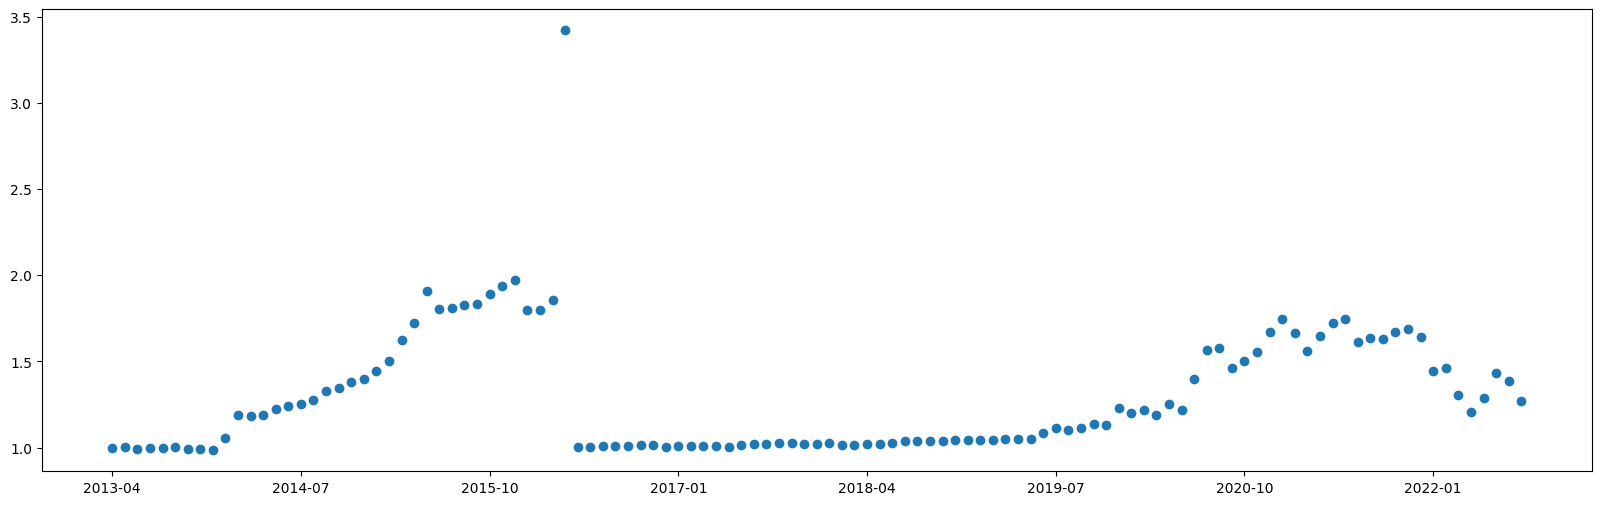

In [35]:

# TODO: why 1.4?
possible_errors = r_t_real.columns[(np.abs(r_t_real) > 1.4).any()]

plt.figure(figsize=(20,6))
this_code_nav = nav[nav.index.get_level_values(0) == possible_errors[0]]
plt.scatter(this_code_nav.index.get_level_values(1), this_code_nav.values)
plt.xticks(this_code_nav.index.get_level_values(1)[::15])
pass

In [36]:
r_t_real_ = r_t_real.drop(possible_errors, axis=1)
pass

In [37]:
stock_fund = np.intersect1d(maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique(), fund_codes)
integrated_fund = np.intersect1d(maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique(), fund_codes)

# TODO: in case use full range funds
# stock_fund = maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique()
# integrated_fund = maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique()

/tmp/ipykernel_1080422/2033080982.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stock_mkt_month = mkt_month[mkt_month.CategoryID == 1].resample('12M').mean()
/tmp/ipykernel_1080422/2033080982.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mixed_mkt_month = mkt_month[mkt_month.CategoryID == 4].resample('12M').mean()


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

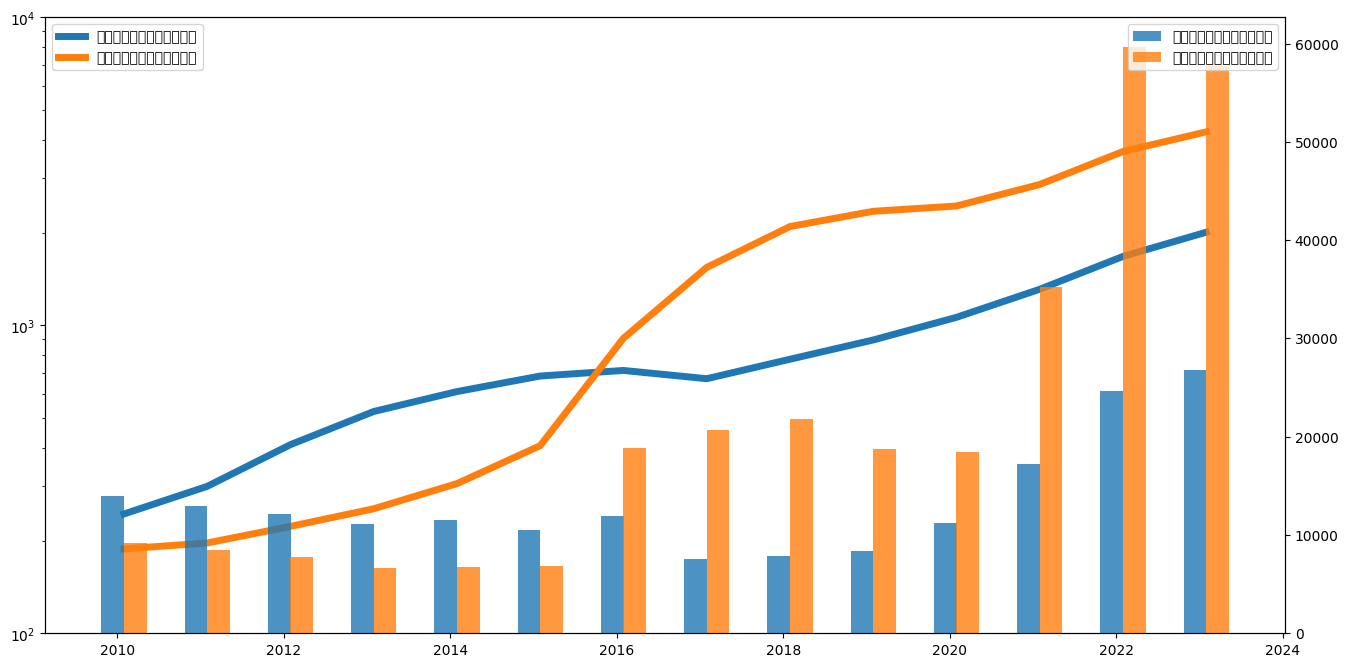

In [38]:
# SgnMonth [统计月份] - null
# CategoryID [基金类型编号] - 0:全部基金;1:股票型基金;2:债券型基金;3:货币型基金;4:混合型基金;5:FOF;6:商品期货型基金;7:REITs;8:其他;21:封闭式基金;22:开放式基金;31:场内基金;32:场外基金;40:ETF基金;50:LOF基金
# TotalFundNAV [基金总资产净值] - 对应类型的所有基金的总资产净值

# TODO: 不一致

stock_mkt_month = mkt_month[mkt_month.CategoryID == 1].resample('12M').mean()
mixed_mkt_month = mkt_month[mkt_month.CategoryID == 4].resample('12M').mean()
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)
ax1.plot(stock_mkt_month.FundNum, linewidth=5, label='股票型基金总数量（折线）')
ax1.plot(mixed_mkt_month.FundNum, linewidth=5, label='混合型基金总数量（折线）')
ax1.set_yscale('log')
ax1.set_yticks([100, 1000, 10000])

ax2 = ax1.twinx()
ax2.bar(stock_mkt_month.index - pd.Timedelta('7W'), stock_mkt_month.TotalFundNAV.values, width=100 ,label='股票型基金总市值（柱状）', alpha=.8)
ax2.bar(mixed_mkt_month.index + pd.Timedelta('7W'), mixed_mkt_month.TotalFundNAV.values, width=100 ,label='混合型基金总市值（柱状）', alpha=.8)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

Text(0.5, 1.0, '「所有」基金管理费率日平均（柱状）/季度平均（折线）')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/pdx01/.local/lib/python3.10/site-package

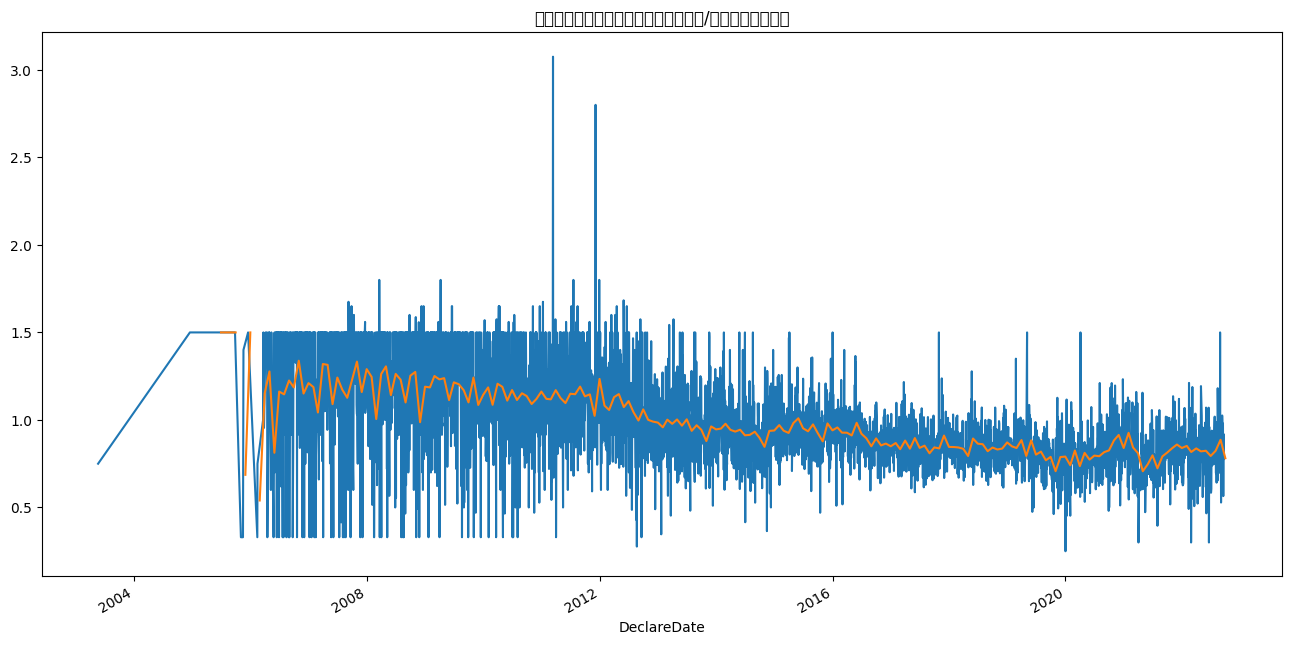

In [39]:
management_fee = fees[fees.NameOfFee == '管理费率']
# TODO: minimal subscription written to management fee
# management_fee[management_fee.ProportionOfFee.astype(float) == 1000]
management_fee_ = management_fee[management_fee.ProportionOfFee.astype(float) != 1000]

# smallest date interval
management_fee__ = management_fee_.groupby('DeclareDate').apply(lambda one_date: one_date.ProportionOfFee.astype(float).mean())
plt.figure(figsize=(16,8))
management_fee__.plot()
management_fee__.resample('1M').mean().plot()
plt.title('「所有」基金管理费率日平均（柱状）/季度平均（折线）')
# TODO: 国泰安数据不全，2006前数据缺失
# TODO: 不一致

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

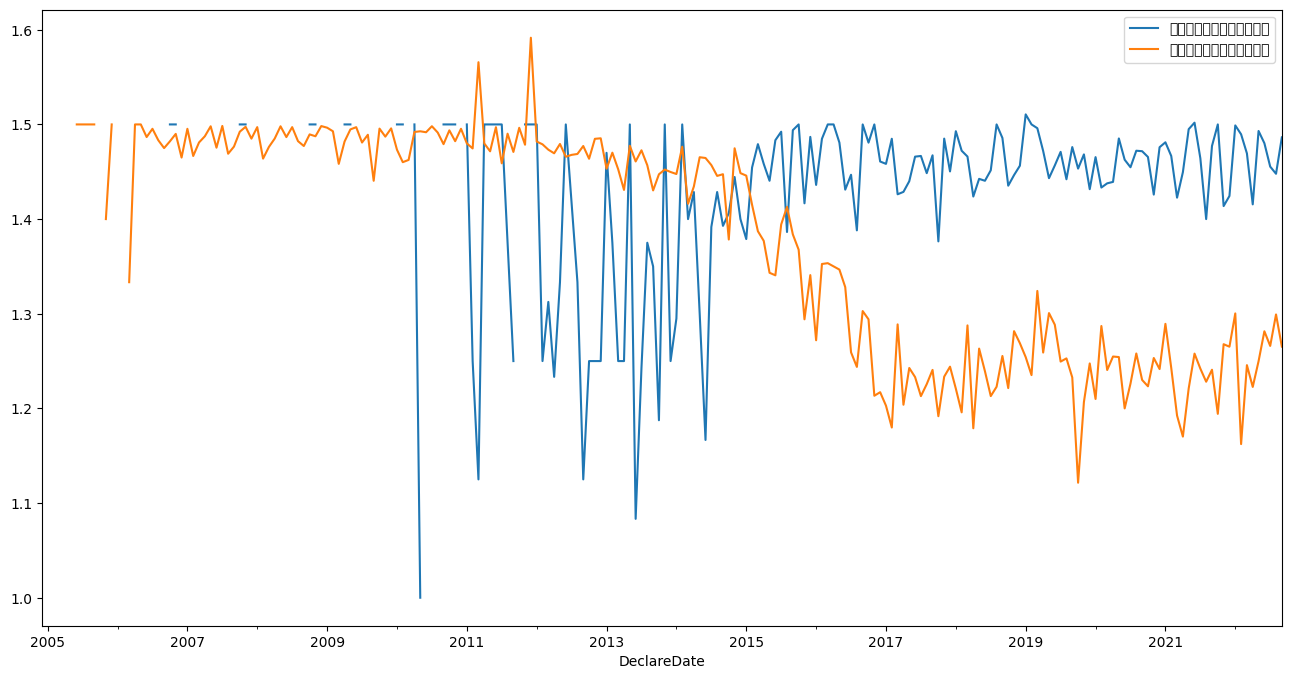

In [40]:
management_fee_stock_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in stock_fund else None)
    
management_fee_integrated_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in integrated_fund else None)

management_fee_stock_fund_ = management_fee_stock_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())
management_fee_integrated_fund_ = management_fee_integrated_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())

plt.figure(figsize=(16,8))
management_fee_stock_fund_.resample('1M').mean().plot(label='股票型基金季度平均管理费')
management_fee_integrated_fund_.resample('1M').mean().plot(label='混合型基金季度平均管理费')
plt.legend()

## II.Select

月末等权重买入一种分类中所有基金

持有一个月，按月滚动调整

**?等金额权重/等份额权重**

In [56]:

# ! S_DQ_ADJCLOSE
stock_avg_change = full.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='S_DQ_CLOSE').pct_change()\
    .apply(lambda date: date.sum()/pd.notnull(date).sum() if date.sum() != 0 else None, axis=1)\
        .loc['2002-1-1':'2022-9-22']

stock_return = (stock_avg_change + 1).cumprod()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

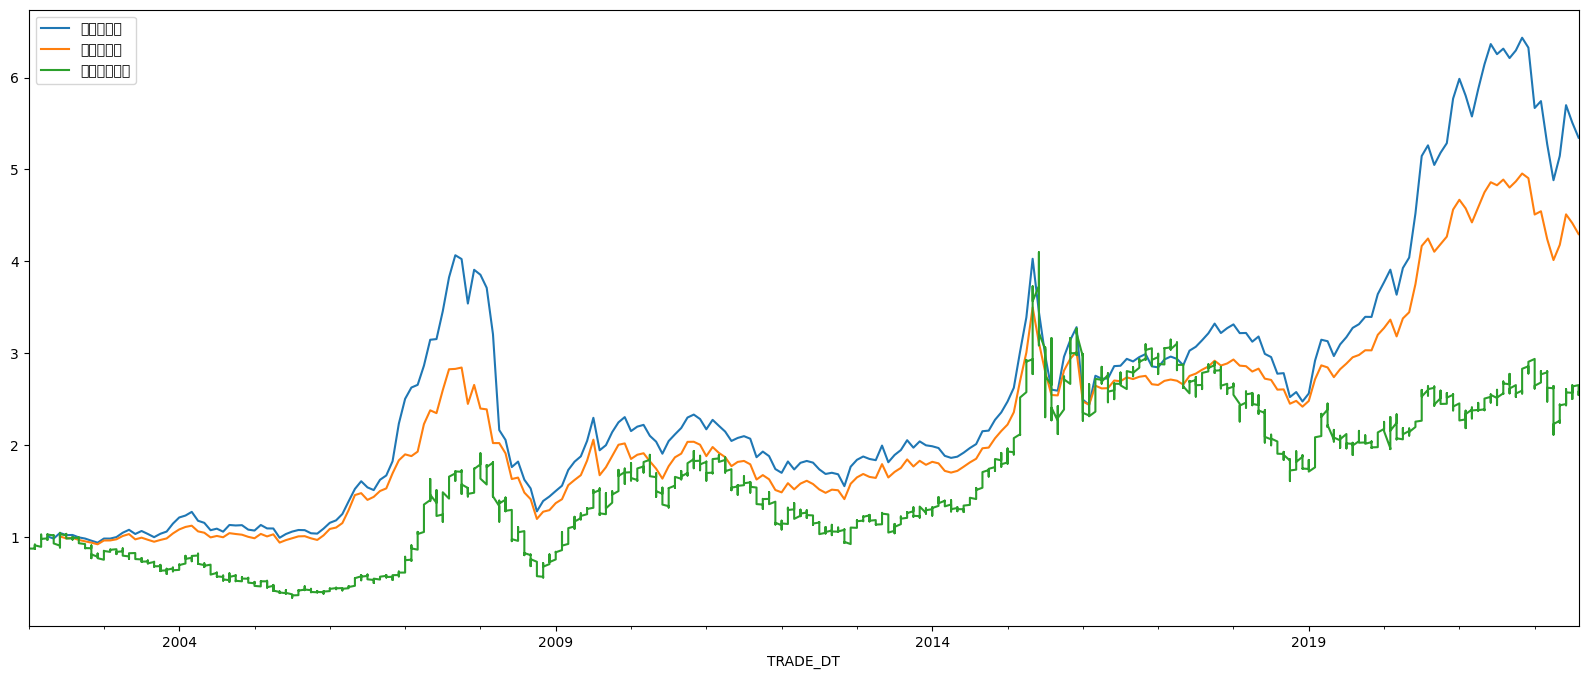

In [57]:
# 等份额权重
# remove all null month
# TODO, probable cause: funds listed before 2022-04 did not meet other requirements

plt.figure(figsize=(20,8))
stock_r_t = r_t_real_[np.intersect1d(stock_fund, r_t_real_.columns)]
stock_r_t_ = stock_r_t[~ pd.isnull(stock_r_t).all(axis=1)]
stock_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='股票型基金')
mixed_r_t = r_t_real_[np.intersect1d(integrated_fund, r_t_real_.columns)]
mixed_r_t_ = mixed_r_t[~ pd.isnull(mixed_r_t).all(axis=1)]
mixed_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='混合型基金')
stock_return.plot(label='股票市场组合')
plt.legend()